## Collaborative Filtering using SVD

In [5]:
!pip install pandas numpy matplotlib seaborn nltk scikit-learn surprise


  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.7 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (6.4 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
  Usin

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split

In [13]:
# Load the cleaned data
data_cleaned = pd.read_csv('cleaned_data_with_features.csv')

# Prepare data for collaborative filtering
reader = Reader(rating_scale=(1, 5))
data_cleaned.rename(columns={'name': 'product', 'reviews.username': 'user', 'reviews.rating': 'rating'}, inplace=True)

data = Dataset.load_from_df(data_cleaned[['user', 'product', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd = SVD()
svd.fit(trainset)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9783  1.0304  1.0205  0.9965  1.0240  1.0099  0.0195  
MAE (testset)     0.7267  0.7598  0.7470  0.7252  0.7481  0.7414  0.0134  
Fit time          0.07    0.07    0.08    0.09    0.08    0.08    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.97833739, 1.03043558, 1.02045708, 0.99654458, 1.02397141]),
 'test_mae': array([0.72674743, 0.75983634, 0.74702458, 0.72524474, 0.74813142]),
 'fit_time': (0.07386136054992676,
  0.07485198974609375,
  0.07955050468444824,
  0.09042668342590332,
  0.08269858360290527),
 'test_time': (0.008278846740722656,
  0.009260892868041992,
  0.011423826217651367,
  0.009556770324707031,
  0.008634567260742188)}

## Content-Based Filtering using TF-IDF and SVD

In [14]:
# Ensure there are no NaN values in the 'processed_reviews' column
data_cleaned['processed_reviews'] = data_cleaned['processed_reviews'].fillna('')

# TF-IDF Vectorization of review text
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(data_cleaned['processed_reviews'])

# Dimensionality reduction using Truncated SVD
svd_truncated = TruncatedSVD(n_components=100)
review_embeddings = svd_truncated.fit_transform(tfidf_matrix)

# Add review embeddings to the dataset
embedding_df = pd.DataFrame(review_embeddings, columns=[f'embedding_{i}' for i in range(100)])
data_cleaned = pd.concat([data_cleaned, embedding_df], axis=1)

# Compute item similarity matrix
item_similarity = cosine_similarity(review_embeddings)


## Hybrid Recommendation System

In [18]:
# Hybrid Model
from sklearn.base import BaseEstimator

class HybridRecommender(BaseEstimator):
    def __init__(self, svd_model=None, item_similarity_matrix=None):
        self.svd_model = svd_model
        self.item_similarity_matrix = item_similarity_matrix

    def fit(self, X, y=None):
        return self

    def predict(self, user_id, item_id):
        try:
            # SVD prediction
            svd_pred = self.svd_model.predict(user_id, item_id).est
            
            # Content-based prediction
            item_idx = data_cleaned[data_cleaned['product'] == item_id].index[0]
            similar_indices = self.item_similarity_matrix[item_idx].argsort()[-11:-1][::-1]
            similar_items = data_cleaned.iloc[similar_indices]['product'].values
            similar_ratings = [self.svd_model.predict(user_id, sim_item).est for sim_item in similar_items]
            content_pred = np.mean(similar_ratings)
            
            # Combine predictions
            return (svd_pred + content_pred) / 2
        except:
            return svd_pred

    def get_params(self, deep=True):
        return {"svd_model": self.svd_model, "item_similarity_matrix": self.item_similarity_matrix}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


# Create the hybrid recommender
hybrid_model = HybridRecommender(svd, item_similarity)

## Evaluations

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Load and preprocess your data
# Assuming data_cleaned is your preprocessed DataFrame
# data_cleaned = pd.read_csv('your_data.csv')

# Create TF-IDF matrix for item features
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data_cleaned['processed_reviews'])

# Apply SVD to reduce dimensions
svd = TruncatedSVD(n_components=50)
item_features_matrix = svd.fit_transform(tfidf_matrix)

# Compute item similarity matrix
item_similarity_matrix = cosine_similarity(item_features_matrix)

# Create SVD model for collaborative filtering
reader = Reader(rating_scale=(0, 5))
surprise_data = Dataset.load_from_df(data_cleaned[['user', 'product', 'rating']], reader)
trainset = surprise_data.build_full_trainset()
svd_model = SVD()
svd_model.fit(trainset)

class HybridRecommender(BaseEstimator):
    def __init__(self, svd_model=None, item_similarity_matrix=None):
        self.svd_model = svd_model
        self.item_similarity_matrix = item_similarity_matrix

    def fit(self, X, y=None):
        return self

    def predict(self, user_id, item_id):
        try:
            # SVD prediction
            svd_pred = self.svd_model.predict(user_id, item_id).est
            
            # Content-based prediction
            item_idx = data_cleaned[data_cleaned['product'] == item_id].index[0]
            similar_indices = self.item_similarity_matrix[item_idx].argsort()[-11:-1][::-1]
            similar_items = data_cleaned.iloc[similar_indices]['product'].values
            similar_ratings = [self.svd_model.predict(user_id, sim_item).est for sim_item in similar_items]
            content_pred = np.mean(similar_ratings)
            
            # Combine predictions
            return (svd_pred + content_pred) / 2
        except:
            return svd_pred

    def get_params(self, deep=True):
        return {"svd_model": self.svd_model, "item_similarity_matrix": self.item_similarity_matrix}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Define the parameter grid and custom scorer
def custom_scorer(estimator, X, y):
    y_pred = [estimator.predict(row['user'], row['product']) for _, row in X.iterrows()]
    return -mean_absolute_error(y, y_pred)

param_grid = {
    'svd_model': [svd_model],
    'item_similarity_matrix': [item_similarity_matrix]
}

hybrid_model = HybridRecommender()

grid_search = GridSearchCV(estimator=hybrid_model, param_grid=param_grid, scoring=make_scorer(custom_scorer), cv=5)
grid_search.fit(data_cleaned[['user', 'product']], data_cleaned['rating'])

print(grid_search.best_params_)

# Now you can use the best estimator
best_model = grid_search.best_estimator_

# Example usage
user_id_example = 'VBSSDV'
product_id_example = 'Microsoft Surface Pro 4 Type Cover with Fingerprint ID'
predicted_rating = best_model.predict(user_id_example, product_id_example)
print(f"Predicted rating for user {user_id_example} on product {product_id_example}: {predicted_rating}")

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.8/site-packages/sklearn/utils/_response.py", line 218, in _get_response_values
    y_pred, pos_label = esti

{'item_similarity_matrix': array([[ 1.        ,  0.33665349,  0.45887392, ...,  0.17659713,
         0.03798008,  0.10731245],
       [ 0.33665349,  1.        ,  0.28064428, ...,  0.12667331,
         0.19351779,  0.19237737],
       [ 0.45887392,  0.28064428,  1.        , ..., -0.02295034,
         0.10390121,  0.11660569],
       ...,
       [ 0.17659713,  0.12667331, -0.02295034, ...,  1.        ,
         0.42598001,  0.12245923],
       [ 0.03798008,  0.19351779,  0.10390121, ...,  0.42598001,
         1.        ,  0.16052829],
       [ 0.10731245,  0.19237737,  0.11660569, ...,  0.12245923,
         0.16052829,  1.        ]]), 'svd_model': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f92f81e5700>}
Predicted rating for user VBSSDV on product Microsoft Surface Pro 4 Type Cover with Fingerprint ID: 4.708508481061052


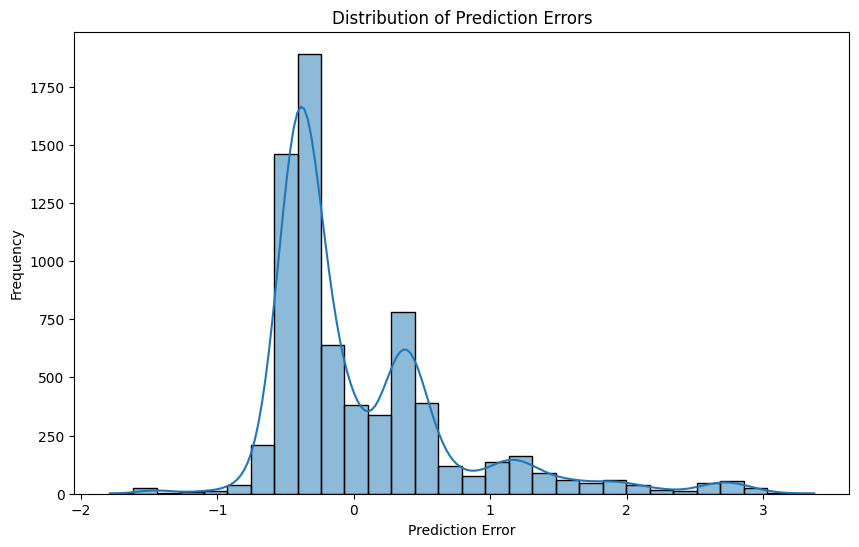

In [21]:
# Get predictions and true values
y_true = data_cleaned['rating']
y_pred = [best_model.predict(row['user'], row['product']) for _, row in data_cleaned.iterrows()]

# Calculate errors
errors = np.array(y_pred) - np.array(y_true)

# Plot distribution of errors
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

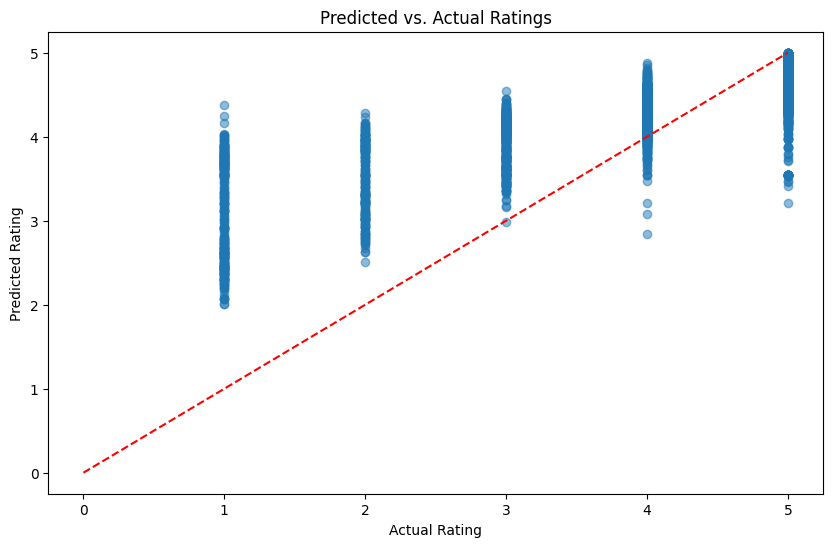

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 5], [0, 5], '--', color='red')
plt.title('Predicted vs. Actual Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.5129
Mean Squared Error (MSE): 0.4904
Root Mean Squared Error (RMSE): 0.7003
